# Solution: Flood Arrival Times Estimation with Convolutional Neural Networks
Many countries such as The Netherlands are subjected to flood risk.
To protect from this hazard, low-lying areas are often proteced by longitudinal wall-like strucutures, such as dikes (or levees).

However, these flood defences can be affected by local failures, due to excessive hydraulic loads (e.g., the flood water overtops the dike) or material weaknesses, among the many reasons.
This leads to so-called dike breach floods, whose main danger is their unexpectedness.
Flood practitioners thus require to understand where and when flood water will reach a given location in the area at risk in order to set up evacuation plans.
A common way to analyse this is via flood arrival time (FAT) maps, which indicate, for each point in the domain, how long it takes for the flood to reach it.


```{figure} ../../../images/flood_arrival_times.png
:scale: 45%
:name: flood_arrival_times

Example of flood arrival time (FAT) map, taken from "Ferrari, A., Dazzi, S., Vacondio, R. and Mignosa, P., 2020. Enhancing the resilience to flooding induced by levee breaches in lowland areas: a methodology based on numerical modelling. Natural Hazards and Earth System Sciences, 20(1), pp.59-72."
```

## Objective

Numerical models for determining the flood arrival times can be very slow, depending on the domain size and complexity.
Moreover, to consider uncertainties in breach formation and location, many simulations must be run, resulting in excessive computational constraints.

Your objective is develop a surrogate model, i.e., a model that replicates the output of another model but faster.
For this exercise, you will use a dataset of pre-run simulations in which the topography changes across the different samples.
You will develop a U-NET style CNN that takes topographical information given by elevation and slopes and predicts the flood arrival times.

```{figure} ../../../images/unet.png
:scale: 45%
:name: unet

Example of U-NET architecture, taken from "Ronneberger, O., Fischer, P. and Brox, T., 2015. U-net: Convolutional networks for biomedical image segmentation. In Medical Image Computing and Computer-Assisted Intervention–MICCAI 2015: 18th International Conference, Munich, Germany, October 5-9, 2015, Proceedings, Part III 18 (pp. 234-241). Springer International Publishing."
```

## Libraries

In [14]:
## Useful libraries
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import os
import copy
import pickle
from urllib.request import urlretrieve
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import TwoSlopeNorm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import Dataset



from cycler import cycler
import seaborn as sns

# Set the color scheme
sns.set_theme()
colors = ['#0076C2', '#EC6842', '#A50034', '#009B77', '#FFB81C', '#E03C31', '#6CC24A', '#EF60A3', '#0C2340', '#00B8C8', '#6F1D77']
plt.rcParams['axes.prop_cycle'] = cycler(color=colors)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Dataset

First load the dataset and explore what the training samples look like.

Train Datasets

In [15]:
length_train_val_data = 80

DEM_train_val = torch.zeros((length_train_val_data, 64, 64))

training = 0.8
validation = 0.2

for k in range(length_train_val_data):
  DEM = np.genfromtxt(f'raw_datasets/DEM/DEM_{k+1}.txt')
  DEM_t = torch.as_tensor(DEM, dtype=torch.float32)


  for x, y, elevation in zip(DEM_t[:,0], DEM_t[:,1], DEM_t[:,2]):
      # Convert coordinates to indices in the 64x64 tensor
      i = int((y - 50) / 100)
      j = int((x - 50) / 100)

      # Assign the elevation value to the corresponding position in the tensor
      DEM_train_val[k, i, j] = elevation

In [16]:
VX_train_val = torch.zeros((length_train_val_data, 97, 64, 64))

training = 0.8
validation = 0.2

for k in range(length_train_val_data):
  VX = np.genfromtxt(f'raw_datasets/VX/VX_{k+1}.txt')
  VX_t = torch.as_tensor(VX, dtype=torch.float32)


  for x, y, elevation in zip(VX_t[:,0], VX_t[:,1], VX_t[:,2]):
      # Convert coordinates to indices in the 64x64 tensor
      i = int((y - 50) / 100)
      j = int((x - 50) / 100)

      # Assign the elevation value to the corresponding position in the tensor
      VX_train_val[k, :, i, j] = elevation

In [17]:
VY_train_val = torch.zeros((length_train_val_data, 97, 64, 64))

training = 0.8
validation = 0.2

for k in range(length_train_val_data):
  VY = np.genfromtxt(f'raw_datasets/VY/VY_{k+1}.txt')
  VY_t = torch.as_tensor(VY, dtype=torch.float32)


  for x, y, elevation in zip(VY_t[:,0], VY_t[:,1], VY_t[:,2]):
      # Convert coordinates to indices in the 64x64 tensor
      i = int((y - 50) / 100)
      j = int((x - 50) / 100)

      # Assign the elevation value to the corresponding position in the tensor
      VY_train_val[k, i, j] = elevation

In [29]:
WD_train_val = torch.zeros((length_train_val_data, 97, 64, 64))

training = 0.8
validation = 0.2

for i in range(length_train_val_data):
  WD = np.genfromtxt(f'raw_datasets/WD/WD_{i+1}.txt')
  WD_t = torch.as_tensor(WD, dtype=torch.float32)

  for k in range(97):
    wd = WD_t[k].reshape((64,64))
    wd = torch.as_tensor(wd)

    WD_train_val[i, k] = wd


In [31]:
length_train_val_data = 80

# Assuming you have a tensor 'WD_train_val' with shape (length_train_val_data, 97, 64, 64)
WD_train_val_reshaped = torch.zeros((length_train_val_data, 24, 64, 64))

for i in range(length_train_val_data):
    WD = np.genfromtxt(f'raw_datasets/WD/WD_{i+1}.txt')
    WD_t = torch.as_tensor(WD, dtype=torch.float32)

    for j in range(24):
        # Extract a 2-hour interval from the original 97 time points
        start_index = j * 4  # Each 2-hour interval has 4 time points (assuming 30 minutes intervals)
        end_index = (j + 1) * 4
        wd = WD_t[j].reshape((64,64))
        wd = torch.as_tensor(wd)
        # Average or concatenate the data over the 2-hour interval, depending on your requirement
        wd_interval = torch.mean(wd[start_index:end_index], dim=0)  # You can use other aggregation functions if needed

        WD_train_val_reshaped[i, j] = wd_interval


In [32]:
input_train_dataset = torch.stack((DEM_train_val, WD_train_val[:,0])).permute(1, 0, 2, 3)

In [33]:
print(input_train_dataset.shape)

torch.Size([80, 2, 64, 64])


In [34]:
output_train_dataset = WD_train_val[:,1:97]

In [35]:
print(output_train_dataset.shape)

torch.Size([80, 96, 64, 64])


In [36]:
train_dataset = []

# Iterate through the samples
for i in range(input_train_dataset.size(0)):
    # Get the tensors for the current sample
    sample_tensor1 = input_train_dataset[i]  # Shape: [2, 64, 64]
    sample_tensor2 = output_train_dataset[i]  # Shape: [96, 64, 64]

    # Append the tensors to the train_dataset list
    train_dataset.append([sample_tensor1, sample_tensor2])

# Convert the list to a PyTorch tensor
# train_dataset = torch.stack([torch.stack(sample) for sample in train_dataset])

print(np.shape(train_dataset))

print(np.shape(train_dataset[0][1]))

(80, 2)
torch.Size([96, 64, 64])


In [37]:
# print(train_dataset.shape)

Test datasets

In [38]:
length_test_data = 20

DEM_test = torch.zeros((length_test_data, 64, 64))

training = 0.8
validation = 0.2

for k in range(length_test_data):
  DEM = np.genfromtxt(f'raw_datasets/DEM/DEM_{k+500}.txt')

  DEM_t = torch.as_tensor(DEM, dtype=torch.float32)


  for x, y, elevation in zip(DEM_t[:,0], DEM_t[:,1], DEM_t[:,2]):
      # Convert coordinates to indices in the 64x64 tensor
      i = int((y - 50) / 100)
      j = int((x - 50) / 100)

      # Assign the elevation value to the corresponding position in the tensor
      DEM_test[k, i, j] = elevation

In [46]:
WD_test = torch.zeros((length_test_data, 97, 64, 64))

training = 0.8
validation = 0.2

for i in range(length_test_data):
  WD = np.genfromtxt(f'raw_datasets/WD/WD_{i+500}.txt')
  WD_t = torch.as_tensor(WD, dtype=torch.float32)

  for k in range(97):
    wd = WD_t[k].reshape((64,64))
    wd = torch.as_tensor(wd)

    WD_test[i, k] = wd


In [47]:
length_test_data = 20

# Assuming you have a tensor 'WD_train_val' with shape (length_train_val_data, 97, 64, 64)
WD_test_reshaped = torch.zeros((length_test_data, 24, 64, 64))

for i in range(length_test_data):
    WD = np.genfromtxt(f'raw_datasets/WD/WD_{i+500}.txt')
    WD_t = torch.as_tensor(WD, dtype=torch.float32)

    for j in range(24):
        # Extract a 2-hour interval from the original 97 time points
        start_index = j * 4  # Each 2-hour interval has 4 time points (assuming 30 minutes intervals)
        end_index = (j + 1) * 4
        wd = WD_t[j].reshape((64,64))
        wd = torch.as_tensor(wd)
        # Average or concatenate the data over the 2-hour interval, depending on your requirement
        wd_interval = torch.mean(wd[start_index:end_index], dim=0)  # You can use other aggregation functions if needed

        WD_test_reshaped[i, j] = wd_interval


In [48]:
input_test_dataset = torch.stack((DEM_test, WD_test[:,0])).permute(1, 0, 2, 3)

In [49]:
print(input_test_dataset.shape)

torch.Size([20, 2, 64, 64])


In [50]:
output_test_dataset = WD_test[:,1:97]

In [51]:
print(output_test_dataset.shape)

torch.Size([20, 96, 64, 64])


In [52]:
test_dataset = []

# Iterate through the samples
for i in range(input_test_dataset.size(0)):
    # Get the tensors for the current sample
    sample_tensor1 = input_test_dataset[i]  # Shape: [2, 64, 64]
    sample_tensor2 = output_test_dataset[i]  # Shape: [96, 64, 64]

    # Append the tensors to the train_dataset list
    test_dataset.append([sample_tensor1, sample_tensor2])

# Convert the list to a PyTorch tensor
# train_dataset = torch.stack([torch.stack(sample) for sample in train_dataset])

print(np.shape(test_dataset))

print(np.shape(test_dataset[0][1]))

(20, 2)
torch.Size([96, 64, 64])


### Plot the inputs and outputs for one example.

Each example corresponds to one full flood simulation, carried out assuming a dike breach flood with constant discharge of $50m^3/s$, starting in the bottom-left corner of the domain.
The domain is a 64x64 grid where each tile/patch is $100m$ in length.

Among the simulations, we change the spatial distribution of the topography.

The inputs and outputs are as follows:

Inputs:
- digital elevation model (DEM)
- slope in the x direction
- slope in the y direction

Output:
- flood arrival time (FAT) map

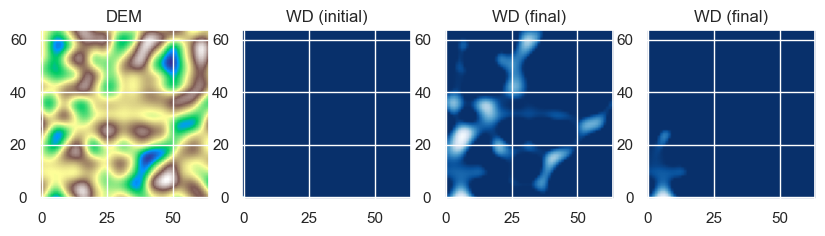

In [53]:
inputs, outputs = train_dataset[0]

fig, axs = plt.subplots(1, 4, figsize=(10, 5))

axs[0].imshow(inputs[0].cpu(), cmap='terrain', origin='lower')
axs[0].set_title('DEM')

axs[1].imshow(inputs[1].cpu(), cmap='Blues_r', origin='lower')
axs[1].set_title('WD (initial)')

axs[2].imshow(outputs[-1].cpu(), cmap='Blues_r', origin='lower')
axs[2].set_title('WD (final)')

axs[3].imshow(outputs[10].cpu(), cmap='Blues_r', origin='lower')
axs[3].set_title('WD (final)')

plt.show()

In [54]:
# print(type(train_dataset[0]).reshape)

Preproccess data

In [55]:
def normalize_dataset(dataset, scaler_x, scaler_y):
    min_x, max_x = scaler_x.data_min_[0], scaler_x.data_max_[0]
    min_y, max_y = scaler_y.data_min_[0], scaler_y.data_max_[0]
    normalized_dataset = []
    for idx in range(len(dataset)):
        x = dataset[idx][0]
        y = dataset[idx][1]
        norm_x = (x - min_x) / (max_x - min_x)
        norm_y = (y - min_y) / (max_y - min_y)
        normalized_dataset.append((norm_x, norm_y))
    return normalized_dataset
# Normalize the inputs and outputs using training dataset
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()


In [56]:
for idx in range(len(train_dataset)):
    scaler_x.partial_fit(train_dataset[idx][0].reshape(inputs.shape[0], -1).T.cpu())
    scaler_y.partial_fit(train_dataset[idx][1].reshape(-1, 1).cpu())


In [57]:
normalized_train_dataset = normalize_dataset(train_dataset, scaler_x, scaler_y)
normalized_test_dataset = normalize_dataset(test_dataset, scaler_x, scaler_y)
# Split dataset into train, validation, and testing
train_percnt = 0.8
train_size = int(train_percnt * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(normalized_train_dataset, [train_size, val_size])

In [58]:
print(normalized_train_dataset[0][0])

print(train_dataset[0][0])

tensor([[[0.4818, 0.4313, 0.3685,  ..., 0.6440, 0.6210, 0.5851],
         [0.5256, 0.4755, 0.4135,  ..., 0.6340, 0.5971, 0.5498],
         [0.5639, 0.5156, 0.4561,  ..., 0.6120, 0.5614, 0.5037],
         ...,
         [0.4614, 0.4430, 0.4097,  ..., 0.6125, 0.6033, 0.5747],
         [0.4605, 0.4475, 0.4210,  ..., 0.5549, 0.5569, 0.5418],
         [0.4625, 0.4540, 0.4329,  ..., 0.5115, 0.5253, 0.5234]],

        [[0.4829, 0.4818, 0.4818,  ..., 0.4818, 0.4818, 0.4818],
         [0.4818, 0.4818, 0.4818,  ..., 0.4818, 0.4818, 0.4818],
         [0.4818, 0.4818, 0.4818,  ..., 0.4818, 0.4818, 0.4818],
         ...,
         [0.4818, 0.4818, 0.4818,  ..., 0.4818, 0.4818, 0.4818],
         [0.4818, 0.4818, 0.4818,  ..., 0.4818, 0.4818, 0.4818],
         [0.4818, 0.4818, 0.4818,  ..., 0.4818, 0.4818, 0.4818]]])
tensor([[[0.4818, 0.4588, 0.4651,  ..., 0.3638, 0.3605, 0.3962],
         [0.5629, 0.5386, 0.5398,  ..., 0.3166, 0.3187, 0.3572],
         [0.6243, 0.5959, 0.5885,  ..., 0.2833, 0.2857, 0.

In [59]:
# Create you own CNN model

# Define the model
# model = ...

# ---------------------- student exercise --------------------------------- #
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, bias=False, batch_norm=True):
        super().__init__()

        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, bias=bias)]
        if batch_norm:
            layers.append(nn.BatchNorm2d(num_features=out_channels))
        layers.append(nn.PReLU())
        layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=padding, bias=bias))

        self.cnnblock = nn.Sequential(*layers)

    def forward(self, x):
        return self.cnnblock(x)

class Encoder(nn.Module):
    def __init__(self, channels=[32, 64, 128], kernel_size=3, padding=1, bias=False, batch_norm=True):
        super().__init__()

        self.enc_blocks = nn.ModuleList([
            CNNBlock(channels[block], channels[block+1], kernel_size, padding, bias,
                     batch_norm=batch_norm)
            for block in range(len(channels)-1)]
            )
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        outs = []
        for block in self.enc_blocks:
            x = block(x)
            outs.append(x)
            x = self.pool(x)
        return outs

class Decoder(nn.Module):
    def __init__(self, channels=[128, 64, 32], kernel_size=3, padding=1, bias=False, batch_norm=True):
        super().__init__()
        self.channels = channels
        self.upconvs = nn.ModuleList([
            nn.ConvTranspose2d(channels[block], channels[block+1], kernel_size=2, padding=0, stride=2)
            for block in range(len(channels)-1)]
            )
        self.dec_blocks = nn.ModuleList([
            CNNBlock(channels[block], channels[block+1], kernel_size, padding, bias,
                     batch_norm=batch_norm)
             for block in range(len(channels)-1)]
             )

    def forward(self, x, x_skips):
        for i in range(len(x_skips)):
            x = self.upconvs[i](x)
            x = torch.cat((x, x_skips[-(1+i)]), dim=1)
            x = self.dec_blocks[i](x)

        x = self.dec_blocks[-1](x)
        return x

class CNN(nn.Module):
    def __init__(self, node_features, out_dim=96, n_downsamples=3, initial_hid_dim=64, batch_norm=True,
                 bias=True):
        super(CNN, self).__init__()
        hidden_channels = [initial_hid_dim*2**i for i in range(n_downsamples)]
        encoder_channels = [node_features]+hidden_channels
        decoder_channels = list(reversed(hidden_channels))+[out_dim]

        self.encoder = Encoder(encoder_channels, kernel_size=3, padding=1,
                               bias=bias, batch_norm=batch_norm)
        self.decoder = Decoder(decoder_channels, kernel_size=3, padding=1,
                               bias=bias, batch_norm=batch_norm)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x[-1], x[:-1])
        x = nn.Sigmoid()(x)
        return x

node_features = train_dataset[0][0].shape[0]
model = CNN(node_features=node_features, n_downsamples=4, initial_hid_dim=32,
            batch_norm=True, bias=True)
# ---------------------- student exercise --------------------------------- #


In [60]:
def train_epoch(model, loader, optimizer, device='cpu'):
    model.to(device)
    model.train() # specifies that the model is in training mode

    losses = []

    for batch in loader:
        x = batch[0]
        y = batch[1]

        # Model prediction
        preds = model(x)

        # MSE loss function
        loss = nn.MSELoss()(preds, y)

        losses.append(loss.cpu().detach())

        # Backpropagate and update weights
        loss.backward()   # compute the gradients using backpropagation
        optimizer.step()  # update the weights with the optimizer
        optimizer.zero_grad(set_to_none=True)   # reset the computed gradients

    losses = np.array(losses).mean()

    return losses

In [61]:
def evaluation(model, loader, device='cpu'):
    model.to(device)
    model.eval() # specifies that the model is in evaluation mode

    losses = []

    with torch.no_grad():
        for batch in loader:
            x = batch[0]
            y = batch[1]

            # Model prediction
            preds = model(x)

            # MSE loss function
            loss = nn.MSELoss()(preds, y)
            losses.append(loss.cpu().detach())

    losses = np.array(losses).mean()

    return losses

In [62]:
# Set training parameters
learning_rate = 0.001
batch_size = 64
num_epochs = 10

# Create the optimizer to train the neural network via back-propagation
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

# Create the training and validation dataloaders to "feed" data to the model in batches
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(normalized_test_dataset, batch_size=batch_size, shuffle=False)

In [63]:
# ---------------------- student exercise --------------------------------- #
#create vectors for the training and validation loss
train_losses = []
val_losses = []

for epoch in range(1, num_epochs+1):
    # Model training
    train_loss = train_epoch(model, train_loader, optimizer, device=device)

    # Model validation
    val_loss = evaluation(model, val_loader, device=device)

    if epoch == 1:
        best_loss = val_loss

    if val_loss<=best_loss:
        best_model = copy.deepcopy(model)
        best_loss = val_loss
        best_epoch = epoch

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if epoch%10 == 0:
        print("epoch:",epoch, "\t training loss:", np.round(train_loss,4),
                            "\t validation loss:", np.round(val_loss,4))

model = copy.deepcopy(best_model)
# ---------------------- student exercise --------------------------------- #

epoch: 10 	 training loss: 0.0105 	 validation loss: 0.1214


In [64]:
test_loss = evaluation(model, test_loader, device=device)
print(test_loss)

0.121928245


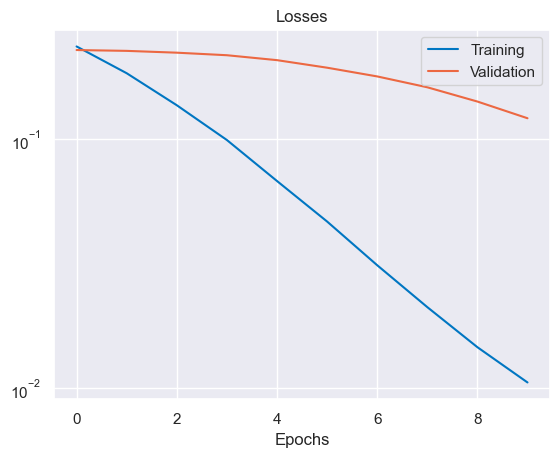

In [65]:
plt.plot(train_losses, label='Training')
plt.plot(val_losses, label='Validation')
plt.yscale('log')
plt.title('Losses')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [66]:
# select one sample
data_id = 10

x = normalized_test_dataset[data_id][0].unsqueeze(0)
FAT = normalized_test_dataset[data_id][1]

# predict the FAT
pred_FAT = model(x).detach()

print(pred_FAT.shape)

torch.Size([1, 96, 64, 64])


In [67]:
DEM = scaler_x.inverse_transform(x[0].reshape(2,-1).T.cpu())[:,0].reshape(64,64)
real_FAT = scaler_y.inverse_transform(FAT[-1].reshape(-1, 1).cpu()).reshape(64,64)
# real_FAT_2 = scaler_y.inverse_transform(FAT.reshape(96,-1).T.cpu()).reshape(64,64)

pred_FAT = scaler_y.inverse_transform(pred_FAT[0][-1].reshape(-1,1).cpu()).reshape(64,64)
# pred_FAT_2 = scaler_y.inverse_transform(pred_FAT.reshape(96,-1).T.cpu()).reshape(64,64)

print(real_FAT.shape)

(64, 64)


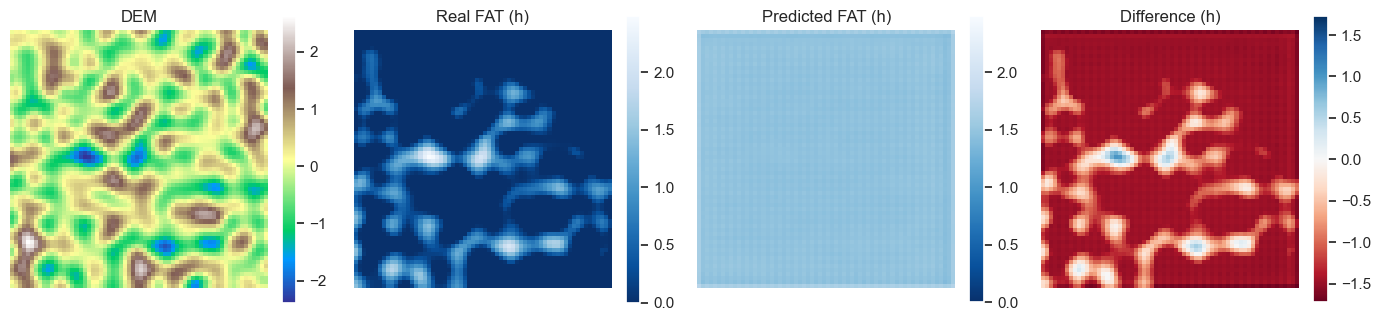

In [68]:
fig, axs = plt.subplots(1, 4, figsize=(17,5))

diff_FAT = real_FAT - pred_FAT
max_FAT = max(pred_FAT.max(), real_FAT.max())
max_diff = max(diff_FAT.max(), -diff_FAT.min())

axs[0].imshow(DEM.squeeze(), cmap='terrain', origin='lower')
axs[1].imshow(real_FAT.squeeze(), vmin = 0, vmax=max_FAT, cmap='Blues_r', origin='lower')
axs[2].imshow(pred_FAT.squeeze(), vmin = 0, vmax=max_FAT,cmap='Blues_r', origin='lower')
axs[3].imshow(diff_FAT.squeeze(), vmin=-max_diff, vmax=max_diff, cmap='RdBu', origin='lower')

plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin = DEM.min(), vmax=DEM.max()),
                            cmap='terrain'), fraction=0.05, shrink=0.9, ax=axs[0])
plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin = 0, vmax=max_FAT),
                            cmap='Blues_r'), fraction=0.05, shrink=0.9, ax=axs[1])
plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin = 0, vmax=max_FAT),
                            cmap='Blues_r'), fraction=0.05, shrink=0.9, ax=axs[2])
plt.colorbar(plt.cm.ScalarMappable(norm=TwoSlopeNorm(vmin=-max_diff, vmax=max_diff, vcenter=0),
                            cmap='RdBu'), fraction=0.05, shrink=0.9, ax=axs[3])
for ax in axs:
    ax.axis('off')

axs[0].set_title('DEM')
axs[1].set_title('Real FAT (h)')
axs[2].set_title('Predicted FAT (h)')
axs[3].set_title('Difference (h)')

plt.show()

In [69]:
model.to(device)
model.eval()

all_preds = []
with torch.no_grad():
    for batch in test_loader:
        x = batch[0]
        y = batch[1]

        # Model prediction
        preds = model(x)
        all_preds.append(preds)

# concatenate all predictions
all_preds = torch.cat(all_preds, dim=0)

# select all outputs from test dataset
test_FAT = torch.stack([normalized_test_dataset[i][1] for i in range(len(normalized_test_dataset))])

# loss on the test dataset per sample
test_loss = torch.stack([nn.MSELoss()(all_preds[i], test_FAT[i]) for i in range(len(all_preds))])

The simulation with the lowest loss is the simulation number: 19
The simulation with the highest loss is the simulation number: 15


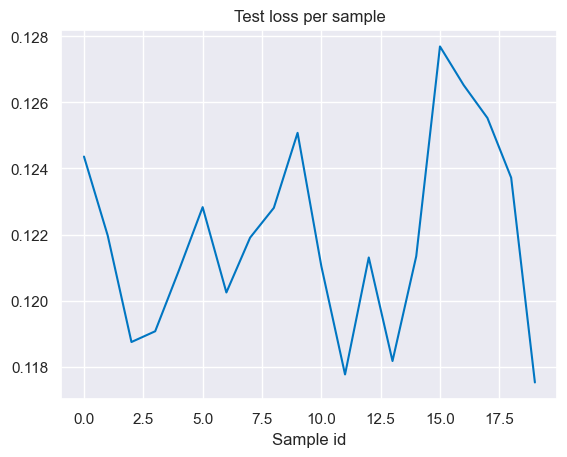

In [70]:
plt.plot(test_loss.cpu())
plt.title('Test loss per sample')
plt.xlabel('Sample id')
print("The simulation with the lowest loss is the simulation number:", test_loss.argmin().item())
print("The simulation with the highest loss is the simulation number:", test_loss.argmax().item())